# Big Data Platform
## Assignment 2: MapReduce

**By:**  

### ID#1: 300123123  
### ID#2: 011996279

<br><br>

**The goal of this assignment is to:**
- Understand and practice the details of MapReduceEngine

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of your team.
- Your solution is in the form of a Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- You are expected to submit a clear and pythonic code.
- You can change functions signatures/definitions.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notebook.
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.
- Late submission won't be allowed.
  
  
- In case of identical code submissions - both groups will get a Zero. 
- Some groups might be selected randomly to present their code.

**Requirements:**  
- Python 3.6 should be used.  
- You should implement the algorithms by yourself using only basic Python libraries (such as numpy,pandas,etc.)

<br><br><br><br>

**Grading:**
- Q1 - 5 points - Initial Steps
- Q2 - 50 points - MapReduceEngine
- Q3 - 30 points - Implement the MapReduce Inverted index of the JSON documents
- Q4 - 5 points - Testing Your MapReduce
- Q5 - 10 points - Final Thoughts 

`Total: 100`

**Prerequisites**

In [1]:
# example
!pip install --quiet zipfile36
!pip install names

**Imports**

In [2]:
# general
import os
import time
import logging
import threading
from threading import Thread
import random
import warnings
import threading # you can use easier threading packages

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display

#random last names
import names

#SQL
import sqlite3
from sqlite3 import Error


**Hide Warnings**

In [4]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [6]:
random.seed(123)

<br><br><br><br>
# Question 1
# Initial Steps

Write Python code to create 20 different CSV files in this format:  `myCSV[Number].csv`, where each file contains 10 records. 

The schema is `(‘firstname’,’secondname’,city’)`  

Values should be randomly chosen from the lists: 
- `firstname` : `[John, Dana, Scott, Marc, Steven, Michael, Albert, Johanna]`  
- `city` : `[New York, Haifa, München, London, Palo Alto,  Tel Aviv, Kiel, Hamburg]`  
- `secondname`: any value  

In [69]:
DB_FILE_NAME='mydb.db'
TEMP_FOLDER='./mapreducetemp'
FINAL_FOLDER='./mapreducefinal'
NUM_OF_RECORDS = 10
TEMP_RESULTS_TBL='temp_results'


In [70]:
def seeder(number):
    firstname = ['John', 'Dana', 'Scott', 'Marc', 'Steven', 'Michael', 'Albert', 'Johanna']
    city = ['NewYork', 'Haifa', 'Munchen', 'London', 'PaloAlto',  'TelAviv', 'Kiev', 'Hamburg']
    secondname = [names.get_last_name() for i in range (10)]

    # create pandas dataframe, populate with random selections of given/generated values
    df = pd.DataFrame()
    df["firstname"] = np.random.choice(firstname, NUM_OF_RECORDS)
    df["secondname"] = np.random.choice(secondname, NUM_OF_RECORDS)
    df["city"] = np.random.choice(city, NUM_OF_RECORDS)

    # write random values generated for {first,second,city} fields to csv
    df.to_csv('MyCSV%s.csv' % number, index=False)
    print("finished creating MyCSV%s.csv" % number)
    
#iterate seeder to create 20 "MyCSV{x}" files from 0-19
for i in range (20):
    seeder(i)

finished creating MyCSV0.csv
finished creating MyCSV1.csv
finished creating MyCSV2.csv
finished creating MyCSV3.csv
finished creating MyCSV4.csv
finished creating MyCSV5.csv
finished creating MyCSV6.csv
finished creating MyCSV7.csv
finished creating MyCSV8.csv
finished creating MyCSV9.csv
finished creating MyCSV10.csv
finished creating MyCSV11.csv
finished creating MyCSV12.csv
finished creating MyCSV13.csv
finished creating MyCSV14.csv
finished creating MyCSV15.csv
finished creating MyCSV16.csv
finished creating MyCSV17.csv
finished creating MyCSV18.csv
finished creating MyCSV19.csv


Use python to Create `mapreducetemp` and `mapreducefinal` folders

In [71]:
try:
    os.mkdir(TEMP_FOLDER) 
    os.mkdir(FINAL_FOLDER)
except:
    print("folder(s) already exist(s)")

<br><br><br>
# Question 2
## MapReduceEngine

Write Python code to create an SQLite database with the following table

`TableName: temp_results`   
`schema: (key:TEXT,value:TEXT)`

In [72]:
sql_create_temp_results_table = """CREATE TABLE IF NOT EXISTS temp_results (
                                    key text,
                                    value text
                                    ); """

In [73]:
sql_group_by_key = """SELECT key, GROUP_CONCAT(value)
                      FROM temp_results GROUP BY key ORDER BY (key);"""

In [74]:
sql_drop_all_tables = """DROP TABLE temp_results;"""

In [75]:
def drop_temp_tables(conn):
    try:
        c = conn.cursor()
        c.execute(sql_drop_all_tables)
    except Error as e:
        print(e)

In [76]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn

In [77]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [78]:
def get_grouped_values(conn):
    cur = conn.cursor()
    cur.execute(sql_group_by_key)

    rows = cur.fetchall()
        
    return rows

In [79]:
connection = create_connection(DB_FILE_NAME)
create_table(connection, sql_create_temp_results_table)

2.6.0


In [80]:
if connection is not None:
    # create temp_results table
    create_table(connection, sql_create_temp_results_table)
else:
    print("Error! cannot create the database connection.")

1. **Create a Python class** `MapReduceEngine` with method `def execute(input_data, map_function, reduce_function)`, such that:
    - `input_data`: is an array of elements
    - `map_function`: is a pointer to the Python function that returns a list where each entry IS of the form (key,value) 
    - `reduce_function`: is pointer to the Python function that returns a list where each entry IS of the form (key,value)

<br><br>

**Implement** the following functionality in the `execute(...)` function:

<br>

1. For each key  from the  input_data, start a new Python thread that executes map_function(key) 
<br><br>
2. Each thread will store results of the map_function into mapreducetemp/part-tmp-X.csv where X is a unique number per each thread.
<br><br>
3. Keep the list of all threads and check whether they are completed.
<br><br>
4. Once all threads completed, load content of all CSV files into the temp_results table in SQLite.

    Remark: Easiest way to loop over all CSV files and load them into Pandas first, then load into SQLite  
    `data = pd.read_csv(path to csv)`  
    `data.to_sql(‘temp_results’,sql_conn, if_exists=’append’,index=False)`
<br><br>

5. **Write SQL statement** that generates a sorted list by key of the form `(key, value)` where value is concatenation of ALL values in the value column that match specific key. For example, if table has records
<table>
    <tbody>
            <tr>
                <td style="text-align:center">John</td>
                <td style="text-align:center">myCSV1.csv</td>
            </tr>
            <tr>
                <td style="text-align:center">Dana</td>
                <td style="text-align:center">myCSV5.csv</td>
            </tr>
            <tr>
                <td style="text-align:center">John</td>
                <td style="text-align:center">myCSV7.csv</td>
            </tr>
    </tbody>
</table>

    Then SQL statement will return `(‘John’,’myCSV1.csv, myCSV7.csv’)`  
    Remark: use GROUP_CONCAT and also GROUP BY ORDER BY
<br><br><br>
6. **Start a new thread** for each value from the generated list in the previous step, to execute `reduce_function(key,value)` 
<br>    
7. Each thread will store results of reduce_function into `mapreducefinal/part-X-final.csv` file  
<br>
8. Keep list of all threads and check whether they are completed  
<br>
9. Once all threads completed, print on the screen `MapReduce Completed` otherwise print `MapReduce Failed` 



In [81]:
class ThreadExecution(Thread):
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None
        
    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args,
                                                **self._kwargs)
    def join(self, *args):
        Thread.join(self, *args)
        return self._return

In [85]:

class MapReduceEngine():
    def execute(self, input_data, map_function, reduce_function, params):
        try: 
            
            # Initialize map threads list
            map_threads_list = []
            map_thread_num = 1
        
            # Creating new instance of ThreadExecution per each csv file in input_data 
            # Starting new thread for each csv file
            for key in input_data:
                map_thread_exec = ThreadExecution(target=map_function, args=(key, params['column']), name=map_thread_num)
                map_thread_exec.start()
                map_threads_list.append(map_thread_exec)
                map_thread_num += 1

            # iterate through thread executions and waiting for threads to complete
            for running_map_thread_exec in map_threads_list:
                map_result = running_map_thread_exec.join()

                # check if result is not none, and if so write to temp csv
                if map_result is not None:
                    map_result_df = pd.DataFrame(map_result, columns=["key", "value"])
                    map_result_df.to_csv(TEMP_FOLDER + '/part-tmp-%s.csv' % running_map_thread_exec.name, index=False, header=True)

            #iterate thru temp folder files and add to SQL temp_results table
            for temp_file_name in os.scandir(TEMP_FOLDER):
                csv_df = pd.read_csv(temp_file_name.path)
                csv_df.to_sql(TEMP_RESULTS_TBL, connection, if_exists='append', index=False)

            #call SQL grouping function ("shuffle step")
            grouped_values = get_grouped_values(connection)

            reduce_threads_list = []
            reduce_thread_num = 1

            #iterate through {key,value} tuples from SQL query and call reduce fcn
            for value in grouped_values:
                reduce_thread_exec = ThreadExecution(target=reduce_function, args=(value[0], value[1]), name=reduce_thread_num)
                reduce_thread_exec.start()
                reduce_threads_list.append(reduce_thread_exec)
                reduce_thread_num += 1

            # iterate through thread executions and waiting for threads to complete
            for running_reduce_thread_exec in reduce_threads_list:
                reduce_result = running_reduce_thread_exec.join()

                # check if result is not none, and if so write to final csv
                if reduce_result is not None:
                    result_df = pd.DataFrame(reduce_result, columns=["values"])
                    result_df.to_csv(FINAL_FOLDER + '/part-%s-final.csv' % running_reduce_thread_exec.name, index=False, header=True)
   
            return "MapReduce Completed"
    
        except:
            print ("MapReduce Failed")

5. **Write SQL statement** that generates a sorted list by key of the form `(key, value)` where value is concatenation of ALL values in the **value** column that match specific key. For example, if table has records
<table>
    <tbody>
            <tr>
                <td style="text-align:center">John</td>
                <td style="text-align:center">myCSV1.csv</td>
            </tr>
            <tr>
                <td style="text-align:center">Dana</td>
                <td style="text-align:center">myCSV5.csv</td>
            </tr>
            <tr>
                <td style="text-align:center">John</td>
                <td style="text-align:center">myCSV7.csv</td>
            </tr>
    </tbody>
</table>

    Then SQL statement will return `(‘John’,’myCSV1.csv, myCSV7.csv’)`  
    **Remark:** use GROUP_CONCAT and also GROUP BY ORDER BY
<br><br><br>

<br><br><br><br>

# Question 3
## Implement the MapReduce Inverted index of the JSON documents

Implement a function `inverted_map(document_name)` which reads the CSV document from the local disc and return a list that contains entries of the form (key_value, document name).

For example, if myCSV4.csv document has values like:  
`{‘firstname’:’John’,‘secondname’:’Rambo’,‘city’:’Palo Alto’}`

Then `inverted_map(‘myCSV4.csv’)` function will return a list:  
`[(‘firstname_John’,’ myCSV4.csv’),(‘secondname_Rambo’,’ myCSV4.csv’), (‘city_Palo Alto’,’ myCSV4.csv’)]`

In [82]:
def inverted_map(document_name, column_index):
    # read csv and skip header row
    values = pd.read_csv(filepath_or_buffer = document_name, usecols=[column_index], skiprows=1)
    
    # return list of {key,value} pair for {keys,files}
    return [(x[0], document_name) for x in values.to_records(index=False)]

Write a reduce function `inverted_reduce(value, documents)`, where the field “documents” contains a list of all CSV documents per given value.   
This list might have duplicates.   
Reduce function will return new list without duplicates.

For example,  
calling the function `inverted_reduce(‘firstname_Albert’,’myCSV2.csv, myCSV5.csv,myCSV2.csv’)`   
will return a list `[‘firstname_Albert’,’myCSV2.csv, myCSV5.csv,myCSV2.csv’]`

In [83]:
def inverted_reduce(value, documents):
    ret_val = [value]
    
    # create a set from documents which reduces duplicates and delimited by commas
    temp_set = set(documents.split(','))
    ret_val.extend(temp_set)
    
    return ret_val

<br><br><br><br>
# Question 4
## Testing Your MapReduce

**Create Python list** `input_data` : `[‘myCSV1.csv’,.. ,‘myCSV20.csv’]`

In [84]:
input_data = []
for number in range(0,20):
    input_data.append('./MyCSV%s.csv' % number)
    
print(input_data)

['./MyCSV0.csv', './MyCSV1.csv', './MyCSV2.csv', './MyCSV3.csv', './MyCSV4.csv', './MyCSV5.csv', './MyCSV6.csv', './MyCSV7.csv', './MyCSV8.csv', './MyCSV9.csv', './MyCSV10.csv', './MyCSV11.csv', './MyCSV12.csv', './MyCSV13.csv', './MyCSV14.csv', './MyCSV15.csv', './MyCSV16.csv', './MyCSV17.csv', './MyCSV18.csv', './MyCSV19.csv']


**Submit MapReduce as follows:**

In [86]:
mapreduce = MapReduceEngine()
status = mapreduce.execute(input_data, inverted_map, inverted_reduce, params={'column':0})
print(status)

MapReduce Completed


Make sure that `MapReduce Completed` should be printed and `mapreducefinal` folder should contain the result files.

**Use python to delete all temporary data from mapreducetemp folder and delete SQLite database:**

In [87]:

# deleting all files in mapreducetemp folder
for file_name in os.scandir(TEMP_FOLDER):
    os.remove(file_name.path)

# delete SQL temp_table and SQL db    
drop_temp_tables(connection)
os.remove(DB_FILE_NAME)

<br><br><br><br>

# Question 5
# Final Thoughts

The phase where `MapReduceEngine` reads all temporary files generated by maps and sort them to provide each reducer a specific key is called the **shuffle step**.

Please explain **clearly** what would be the main problem of MapReduce when processing Big Data, if there is no shuffle step at all, meaning reducers will directly read responses from the mappers.

            If you say "I dont know" you will get 2 points :)

### First Answer:
- "I don't know"
- **We** don't know 😂

### Secondary Answer:

Benefits of Shuffling & Sorting:

Shuffling transfers data from mappers to reducers, with reducers receiving a set of aggregated values for specific keys, so clearly this step is needed as otherwise there would be incomplete data received by the reducers. Shuffling ensures that the {key,value} map output is grouped and sent to the correct reducer, so that each reducer receives all entries belonging to each unique key. Without the shuffle step, different reducers could end up working on different entries of the same key, which is likely to result in errors in the reduce function / output. Without shuffling, in this assignment, each reducer would have received set of values for each key in a **given file** vs. getting all values for a specific key in **all files**. In a big data context, the difference between reducing values for keys in one file vs. all files can become enormous, and not having the shuffle step would likely render MapReduce utterly useless. 

Shuffling can also save significant running time as it can start before the mappers are 100% complete. 

Sorting also has several benefits to the reducer. It makes it easier for the reducer to tell when a new reduce function has to be called, each time the key is different than the previous key, when it's pre-sorted. Receiving pre-sorted {key,value} lists is also easier and saves run-time compelxity for the reducers since each reducer can receive many different lists from different mappers, and then simply has to run merge-functions to merge-sort pre-sorted lists (which is the easier and faster "conquer" phase of merge-sort's "divide & conquer" algorithm). 

To summarize **CLEARLY**, the main problems if there were no shuffle step at all:

1) Mapped {key,value} data received by reducers would not be grouped by key, so the substance of the map output received by reducers would be compromised and contrary to the purpose of the Reduce function, significantly limiting the scope and usefulness of the Reduce function, and resulting  in conflicting reduce workers attempting to reduce different entries of the same key, leading to incorrect and likely not useful reduce output. 

2) Run-time could be significantly longer, for several reasons

3) Reducers would be more prone to error and failures, and would have significantly more "work" to do, some of which may be outside their scope

**References:** 

- https://stackoverflow.com/questions/22141631/what-is-the-purpose-of-shuffling-and-sorting-phase-in-the-reducer-in-map-reduce
- Hadoop_ The Definitive Guide - Tom White - Google Books.html (pages 210-213 - Reducer)

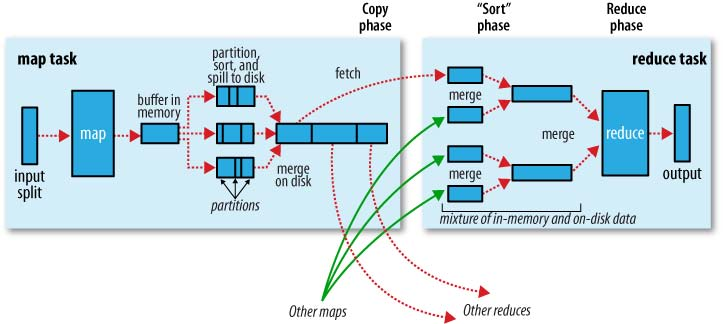

<br><br><br><br>
Good Luck :)